In [1]:
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tqdm.pandas()

# Amazon Reviews Dataset Preparation

## Loading dataset

In [2]:
userReviews = load_dataset('McAuley-Lab/Amazon-Reviews-2023','raw_review_Office_Products',trust_remote_code=True)
#metadata = load_dataset('McAuley-Lab/Amazon-Reviews-2023','raw_meta_Office_Products',split='full',trust_remote_code=True)

In [3]:
df_full = userReviews['full'].to_pandas()
df_full.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Pretty & I love it!,Lovely ink. Writes well. The right amount of w...,[],B01AHHL4X2,B01MZ3SD2X,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677939345945,0,True
1,4.0,2 excellent 1 extremely dry (blue),Overall I’m pretty happy with this purchase bc...,[],B08L6H23JZ,B08L6H23JZ,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1677939160682,0,True
2,1.0,I don’t get the reviews. Mine are garbage.,[[VIDEOID:63276c19932aa4f3687042b8b9f8613c]] U...,[],B07JDZ5J46,B07JDZ5J46,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1660188831933,2,True
3,4.0,Ordering Ink online: never a good idea I guess.,"It’s a beautiful color, but even though it had...","[{'attachment_type': 'IMAGE', 'large_image_url...",B004MNX7EW,B07BR2PBJN,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1659806066713,0,True
4,3.0,Mine are iffy at best.,Idk if I just got a bad batch which is possibl...,[],B019YLRFFS,B097SFY5ZS,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1659799390978,0,True


## Filtering

In [4]:
### Extracting (user,query,item) triplets

# Let's say we only keep if rating > 3.
# ~200 reviews are below or = 3 and ~500 are above 3.

def min_rating(row):
    return row > 3

df_triplets = df_full[df_full['rating'].progress_apply(min_rating)][['user_id','asin','text']]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12845712/12845712 [00:05<00:00, 2348542.04it/s]


In [5]:
df_triplets.head()

,user_id,asin,text
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B01AHHL4X2,Lovely ink. Writes well. The right amount of w...
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B08L6H23JZ,Overall I’m pretty happy with this purchase bc...
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B004MNX7EW,"It’s a beautiful color, but even though it had..."
8,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00KG08EYS,Literally one of the worst packing jobs I’ve s...
12,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00FWRVUJ6,New to this brand & as a huge fan & collector ...


In [6]:
def get_len(row):
    return len(row.split())

df_triplets['len'] = df_triplets['text'].apply(get_len)

In [7]:
# Let's filter also by length of the review
# We will keep only reviews with more than 5 words
# This drops about 100k reviews

def min_size(row):
    return row > 5

df_triplets = df_triplets[df_triplets['len'].progress_apply(min_size)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10103878/10103878 [00:03<00:00, 2620943.38it/s]


In [8]:
before_len = len(df_triplets)

df_triplets = df_triplets.drop_duplicates(subset=['user_id', 'asin', 'text'])

print("Duplicates: ", before_len - len(df_triplets))

Duplicates:  77958


(array([7.727468e+06, 1.148330e+05, 1.770400e+04, 5.080000e+03,
        1.799000e+03, 7.970000e+02, 3.480000e+02, 1.810000e+02,
        1.020000e+02, 6.000000e+01, 3.300000e+01, 3.000000e+01,
        1.400000e+01, 8.000000e+00, 1.100000e+01, 7.000000e+00,
        7.000000e+00, 4.000000e+00, 2.000000e+00, 1.000000e+00,
        5.000000e+00, 0.000000e+00, 3.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 3.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([   6.        ,  179.73333333,  353.46666667,  527.2       ,
         700.93333333,  874.66666667, 1048.4       , 1222.13333333,
        1395.86666667, 1569.6       , 1743.33333333, 1917.06666667,
        2090.8       , 2264.53333333, 2438.26666667, 2612.        ,
        2785.73333333, 2959.46666667, 3133.2       , 3306.93333333,
        3480.66666667, 3654.4       , 3828.13333333, 4001.86666667,
        4175.6       , 4349.33333333, 4523.06666667, 4696.8       ,
        4870.53333333, 5044.26666667, 

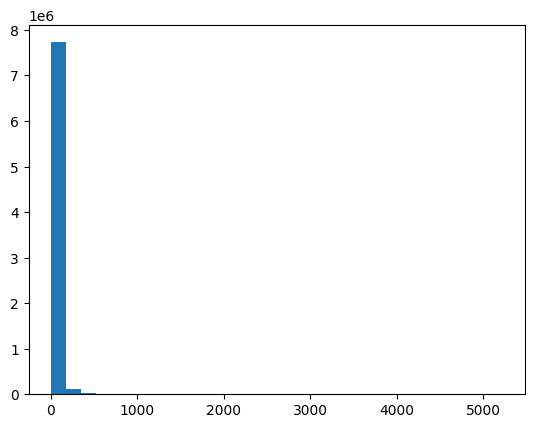

In [9]:
plt.hist(df_triplets['len'], bins=30)

In [10]:
df_triplets[df_triplets['len'] > 200]

,user_id,asin,text,len
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B004MNX7EW,"It’s a beautiful color, but even though it had...",413
8,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00KG08EYS,Literally one of the worst packing jobs I’ve s...,242
12,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00FWRVUJ6,New to this brand & as a huge fan & collector ...,231
14,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B09KLJ9NJH,It’s a nice heavy journal with thick pages. T...,201
15,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B06XY7YNHG,My review is whacked bc I received the wrong p...,245
...,...,...,...,...
12844841,AGJL3GIHUNBLD7ZWFFJI3L5HUOBQ,B006TM8L3Q,These pens are absolutely fabulous. And here's...,268
12845309,AHGHQUIU3CQOCBNBCQ5M22IIDBMQ,B001TQ854C,I bought this sharpener two years ago. Like a...,203
12845372,AG7QWNXWVY7AGICYUDJAMTGVQHFQ,B00P2USAQY,I have an IKEA desk that is a few years old. I...,246
12845498,AG6WX6ENBWPSM6BK32JFWLVRU3WQ,B00000J52W,"I have to admit, I was a bit sceptical when I ...",301


In [11]:
df_g = df_triplets.groupby(by=['text', 'user_id'])['asin'].progress_apply(lambda x: list(x)[:1]).reset_index()

valid_rows = {}

for t, u, a in zip(df_g['text'], df_g['user_id'], df_g['asin']):
    a = a[0]
    valid_rows[f"{t}_{u}_{a}"] = 0

def is_valid(row):
    t = row['text']
    u = row['user_id']
    a = row['asin']
    k = f"{t}_{u}_{a}"
    if k in valid_rows:
        return True
    return False

df_triplets = df_triplets[df_triplets.progress_apply(is_valid, axis=1)]
len(df_triplets)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7868502/7868502 [00:53<00:00, 146113.86it/s]


7822895

In [12]:
before_len = 0

while before_len != len(df_triplets):

    before_len = len(df_triplets)

    valid_users = df_triplets.groupby(by=['user_id']).count().reset_index()
    valid_users = valid_users[valid_users['len'] >= 5]['user_id']
    print("Valid users: ", len(valid_users))

    df_triplets = df_triplets[df_triplets['user_id'].isin(valid_users)]
    print("Filtered by user: ", len(df_triplets))
    print("---")

    valid_items = df_triplets.groupby(by=['asin']).count().reset_index()
    valid_items = valid_items[valid_items['len'] >= 5]['asin']
    print("Valid items: ", len(valid_items))

    df_triplets = df_triplets[df_triplets['asin'].isin(valid_items)]
    print("Filtered by item: ", len(df_triplets))
    print("---")

Valid users:  166396
Filtered by user:  1357208
---
Valid items:  61636
Filtered by item:  960163
---
Valid users:  88731
Filtered by user:  719584
---
Valid items:  46335
Filtered by item:  670310
---
Valid users:  76382
Filtered by user:  623629
---
Valid items:  43084
Filtered by item:  611367
---
Valid users:  73080
Filtered by user:  598392
---
Valid items:  42138
Filtered by item:  594679
---
Valid users:  72024
Filtered by user:  590484
---
Valid items:  41823
Filtered by item:  589229
---
Valid users:  71717
Filtered by user:  588002
---
Valid items:  41728
Filtered by item:  587623
---
Valid users:  71600
Filtered by user:  587155
---
Valid items:  41695
Filtered by item:  587023
---
Valid users:  71556
Filtered by user:  586847
---
Valid items:  41683
Filtered by item:  586799
---
Valid users:  71540
Filtered by user:  586735
---
Valid items:  41681
Filtered by item:  586727
---
Valid users:  71538
Filtered by user:  586719
---
Valid items:  41681
Filtered by item:  586719
--

In [13]:
df_triplets.to_csv('./data/amazon.tsv',sep='\t',index=False)

## Split into train, test, val

In [14]:
df_triplets.head()

,user_id,asin,text,len
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B01AHHL4X2,Lovely ink. Writes well. The right amount of w...,41
8,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00KG08EYS,Literally one of the worst packing jobs I’ve s...,242
12,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B00FWRVUJ6,New to this brand & as a huge fan & collector ...,231
15,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B06XY7YNHG,My review is whacked bc I received the wrong p...,245
17,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B07T4NX5F6,I’m a book freak & I adore mine! I use founta...,212


In [32]:
df_query = {"query_idx": [], "text": []}

for i, t in enumerate(df_triplets.drop_duplicates(subset=['user_id', 'text'])['text']):
    df_query['query_idx'].append(i)
    df_query['text'].append(t)

df_query = pd.DataFrame(df_query)
df_query.head()

,query_idx,text
0,0,Lovely ink. Writes well. The right amount of w...
1,1,Literally one of the worst packing jobs I’ve s...
2,2,New to this brand & as a huge fan & collector ...
3,3,My review is whacked bc I received the wrong p...
4,4,I’m a book freak & I adore mine! I use founta...


In [33]:
df_query.to_csv("./data/queries.tsv", sep='\t', index=False)

In [34]:
df_user = {"user_idx": [], "user_id": []}

for i, t in enumerate(df_triplets.drop_duplicates(subset=['user_id'])['user_id']):
    df_user['user_idx'].append(i)
    df_user['user_id'].append(t)

df_user = pd.DataFrame(df_user)
df_user.head()

,user_idx,user_id
0,0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ
1,1,AGGZ357AO26RQZVRLGU4D4N52DZQ
2,2,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ
3,3,AFSKPY37N3C43SOI5IEXEK5JSIYA
4,4,AHGAOIZVODNHYMNCBV4DECZH42UQ


In [35]:
df_user.to_csv("./data/user_idxs.tsv", sep='\t', index=False)

In [36]:
df_item = {"item_idx": [], "asin": []}

for i, t in enumerate(df_triplets.drop_duplicates(subset=['asin'])['asin']):
    df_item['item_idx'].append(i)
    df_item['asin'].append(t)

df_item = pd.DataFrame(df_item)
df_item.head()

,item_idx,asin
0,0,B01AHHL4X2
1,1,B00KG08EYS
2,2,B00FWRVUJ6
3,3,B06XY7YNHG
4,4,B07T4NX5F6


In [37]:
df_item.to_csv("./data/item_idxs.tsv", sep='\t', index=False)

In [38]:
asin_to_itemidx = {a: i for i, a in zip(df_item['item_idx'], df_item['asin'])}
userid_to_useridx = {a: i for i, a in zip(df_user['user_idx'], df_user['user_id'])}
text_to_queryidx = {a: i for i, a in zip(df_query['query_idx'], df_query['text'])}

In [39]:
def get_user_idx(row):
    return userid_to_useridx[row]

df_triplets['user_idx'] = df_triplets['user_id'].apply(get_user_idx)

In [40]:
def get_item_idx(row):
    return asin_to_itemidx[row]

df_triplets['item_idx'] = df_triplets['asin'].apply(get_item_idx)

In [41]:
def get_query_idx(row):
    return text_to_queryidx[row]

df_triplets['query_idx'] = df_triplets['text'].apply(get_query_idx)

In [42]:
df_g = df_triplets.groupby(by=['query_idx', 'user_idx']).count().reset_index()
len(df_g[df_g['item_idx'] > 1]), len(df_g[df_g['item_idx'] <= 1])

(0, 586719)

In [43]:
df_triplets[df_triplets['user_idx'] == 1301]

,user_id,asin,text,len,user_idx,item_idx,query_idx
70737,AEJ2WLJ5HJELSEX7WOJDPVHA66WQ,B000Q2ZYDA,My husband and I use this board to keep track ...,51,1301,12590,19845
70739,AEJ2WLJ5HJELSEX7WOJDPVHA66WQ,B0091G9FGO,I bought this card for my daughter in law to b...,21,1301,5381,19846
70741,AEJ2WLJ5HJELSEX7WOJDPVHA66WQ,B0024KI8PS,Every year I send my step daughter and her dau...,54,1301,10311,19847
70742,AEJ2WLJ5HJELSEX7WOJDPVHA66WQ,B005KQB22E,I love these socks. I bought a pair at Big Fi...,44,1301,12591,19848
70743,AEJ2WLJ5HJELSEX7WOJDPVHA66WQ,B005KQB3MI,Yeah ... I'm all ready for winder and cold wea...,47,1301,12592,19849


In [44]:
df_data = df_triplets.groupby(by=['query_idx', 'user_idx'])['item_idx'].apply(lambda x: list(x)[:1]).reset_index()
df_data.head()

,query_idx,user_idx,item_idx
0,0,0,[0]
1,1,0,[1]
2,2,0,[2]
3,3,0,[3]
4,4,0,[4]


In [45]:
df_data['item_idxs'] = df_data['item_idx']

In [46]:
df_data = df_data[['query_idx', 'user_idx', 'item_idxs']]

In [47]:
train, test = train_test_split(df_data, test_size=0.2, stratify=df_data['user_idx'], random_state=0)
val, test = train_test_split(test, test_size=0.5, random_state=0) # stratify=test['user_idx'],

In [48]:
len(train), len(val), len(test)

(469375, 58672, 58672)

In [49]:
train.to_csv("./data/training/train_split.tsv", sep='\t', index=False)
val.to_csv("./data/training/val_split.tsv", sep='\t', index=False)
test.to_csv("./data/training/test_split.tsv", sep='\t', index=False)